# Data Reduction Pipeline
### Inputs: Observation name, number, duration, and date
### Outputs: Fits file of reduced data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
import warnings
from astropy.io import fits
import subprocess
import os

params = {
'xtick.direction': 'in',
'ytick.direction': 'in',
}
plt.rcParams.update(params)
plt.rc('figure', figsize=(20.0, 10.0))
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'],'size':15})
plt.rc('text', usetex=True)
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='retina'

### Note: Typically, I would call these from other files or make a class, but, for human readability, they have all been kept in the same notebook.

All that remains is to make a date list which will take 2 minutes, but it is 10 am.

In [2]:
#[name, starting observation number, number of observations, exposure time in seconds, date of observation]
science = ['Pluto'  , 1193, 6, 30, '09/19'] #can also be read in from obs log
dark    = ['dark20s', 1016, 5, 20, '09/19']
flat    = ['skyflat', 1136, 5, 10, '09/19']
biases  = ['bias'   , 1001, 5, 0,  '09/19']

In [3]:
def FitsStack(datatuple):
    runname, start, n_obs, dur, day = datatuple
    field_stack = (fits.getdata('observing_data/d'+str(start)+'.fits')).astype(float)
    for i in range(1,n_obs):
        number = str(start+i)
        name = 'observing_data/d'
        temp_field = (fits.getdata(name+number+'.fits')).astype(float)
        field_stack = np.dstack((field_stack,temp_field))
   
    return field_stack    

In [4]:
def ObserveReducer(science,dark,flat,biases,plot=True,vmin=30,vmax=70):
    '''Reduces NICKEL observations by subtracting out flat fields, dark fiels, and bias.
    
    Parameters: science - tuple; 
                        write to fits file name, - string; e.g. 'Pluto' 
                        observation start number, - int; first number in series to append to read filename, e.g., 'd1001.fits'
                        number of observations, - int; 
                        exposure time, - int; in s.
                        date - string; 'month/day' format, include 0 in front of single digits.   
                n_science_obs - int; 
                        Number of science observations.
                dark - tuple; 
                        Same as science. 
                flat - tuple;
                        Same as science.
                bias - tuple;
                        Same as science.
                n_obs - int; 
                        Number of calibration observations.
                durations - list or arraylike;
                        (dark, flat, science)
                plot - boolean;
                        True: Plots an image. False: Does not.
                vmin, vmax - int;
                        Flux range for the imshow colorbar. Default = Reduced Pluto.
    Out: Fits files of: Medianed bias - 'bias.fits'
                                 dark - dark[0]+'.fits'
                                 flat field - flat[0]+'.fits'
                                 observation - science[0]+'.fits'
                        Dark Image - 'per_second_'+dark[0]+'.fits'
                        Flat field image - 'per_second_'+flat[0]+'.fits'
                        Reduced science image - science[0]+'.fits'                  
                
    '''
    
    s1 = np.arange(science[1],science[1]+science[2])
    s2 = np.arange(dark[1],dark[1]+dark[2])
    s3 = np.arange(flat[1],flat[1]+flat[2])
    s4 = np.arange(biases[1],biases[1]+biases[2])
    idnum_list = np.concatenate((s1,s2,s3,s4))
    date_list = []
    [date_list.append(science[4]) for i in range(science[2])]
    [date_list.append(dark[4]) for i in range(dark[2])]
    [date_list.append(flat[4]) for i in range(flat[2])]
    [date_list.append(biases[4]) for i in range(biases[2])]
    # idnum_list = s1
    print(idnum_list)


    for idnum,date in zip(idnum_list,date_list):
        file = 'observing_data/d'+str(idnum)+'.fits'
        if os.path.exists(file):
            os.remove(file)
        date=science[4]
        cmd = 'wget --user a.skemer --password ASTR_257 http://mtham.ucolick.org/data/2021-'+date+'/nickel/Andrew.Skemer/d'+str(idnum)+'.fits -P observing_data/'
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()

    bias_median = np.median(FitsStack(biases),axis=2)
    bias = bias_median
    for i in range(1,biases[2]): #number of obs
        bias = np.dstack((bias,bias_median))
    fits.writeto(biases[0]+'.fits',bias_median,overwrite=True)

    darkFields = FitsStack(dark)
    flatFields = FitsStack(flat)
    
    # di = (d - b)/20
    # fi = ((f - b)/10 - di)
    # s = ((c - b)/30 - di) / (fi / np.nanmax(fi))
    
    darkImages = (darkFields - bias) / dark[3]
    flatImages = ((flatFields - bias) / flat[3] - darkImages) #normalizing to make range better
    darkImage_median = np.median(darkImages,axis=2)
    flatImage_median = np.median(flatImages,axis=2)
    
    fits.writeto('per_second_'+dark[0]+'.fits', darkImage_median,overwrite=True)
    fits.writeto('per_second_'+flat[0]+'.fits', flatImage_median,overwrite=True)
            
    science_name = science[0]
    counts = np.median(FitsStack(science),axis=2)

    plt.title(science_name+' Unreduced')
    plt.imshow(counts,origin='lower',vmin=1000,vmax=4000)
    plt.colorbar()
    plt.show()
    science_data = ((counts-bias_median)/science[3] - darkImage_median) / (flatImage_median/np.nanmax(flatImage_median))
    #normalizing the flat image to make the view range more reasonable

    fits.writeto("reduced_"+science_name+".fits",science_data,overwrite=True) 
    
    plt.figure()
    plt.title(science_name+' Reduced')
    plt.imshow(science_data,origin='lower',vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.show()

[1193 1194 1195 1196 1197 1198 1016 1017 1018 1019 1020 1136 1137 1138
 1139 1140 1001 1002 1003 1004 1005]


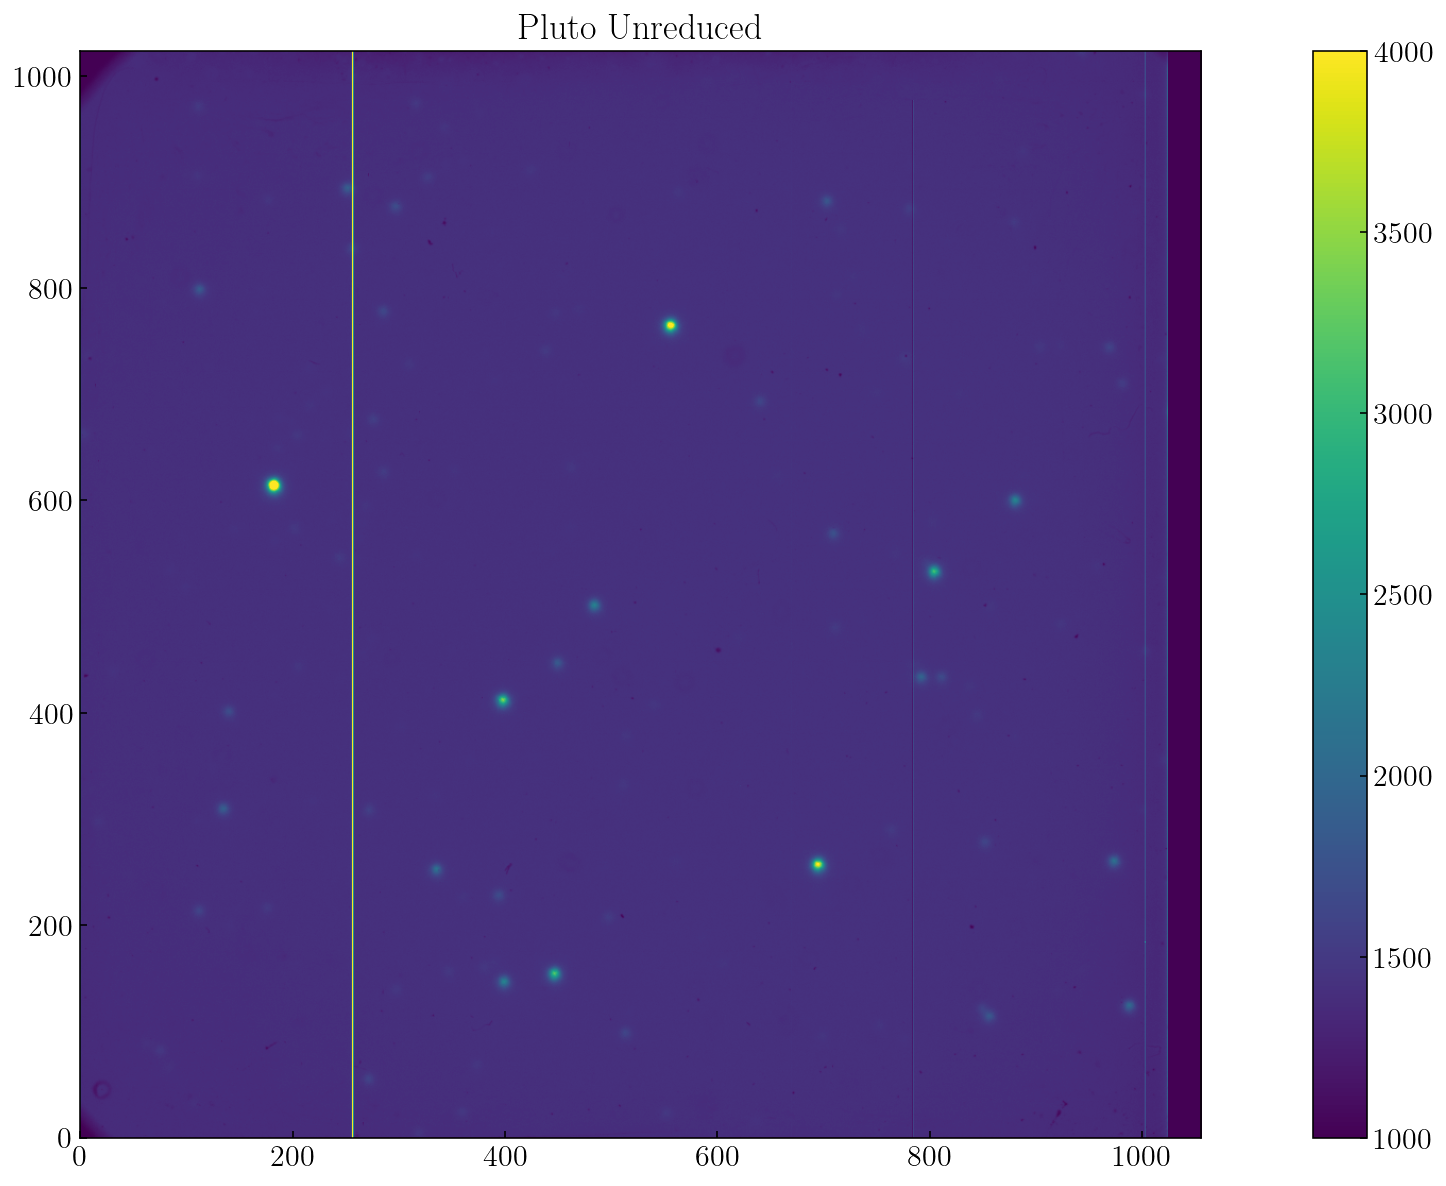

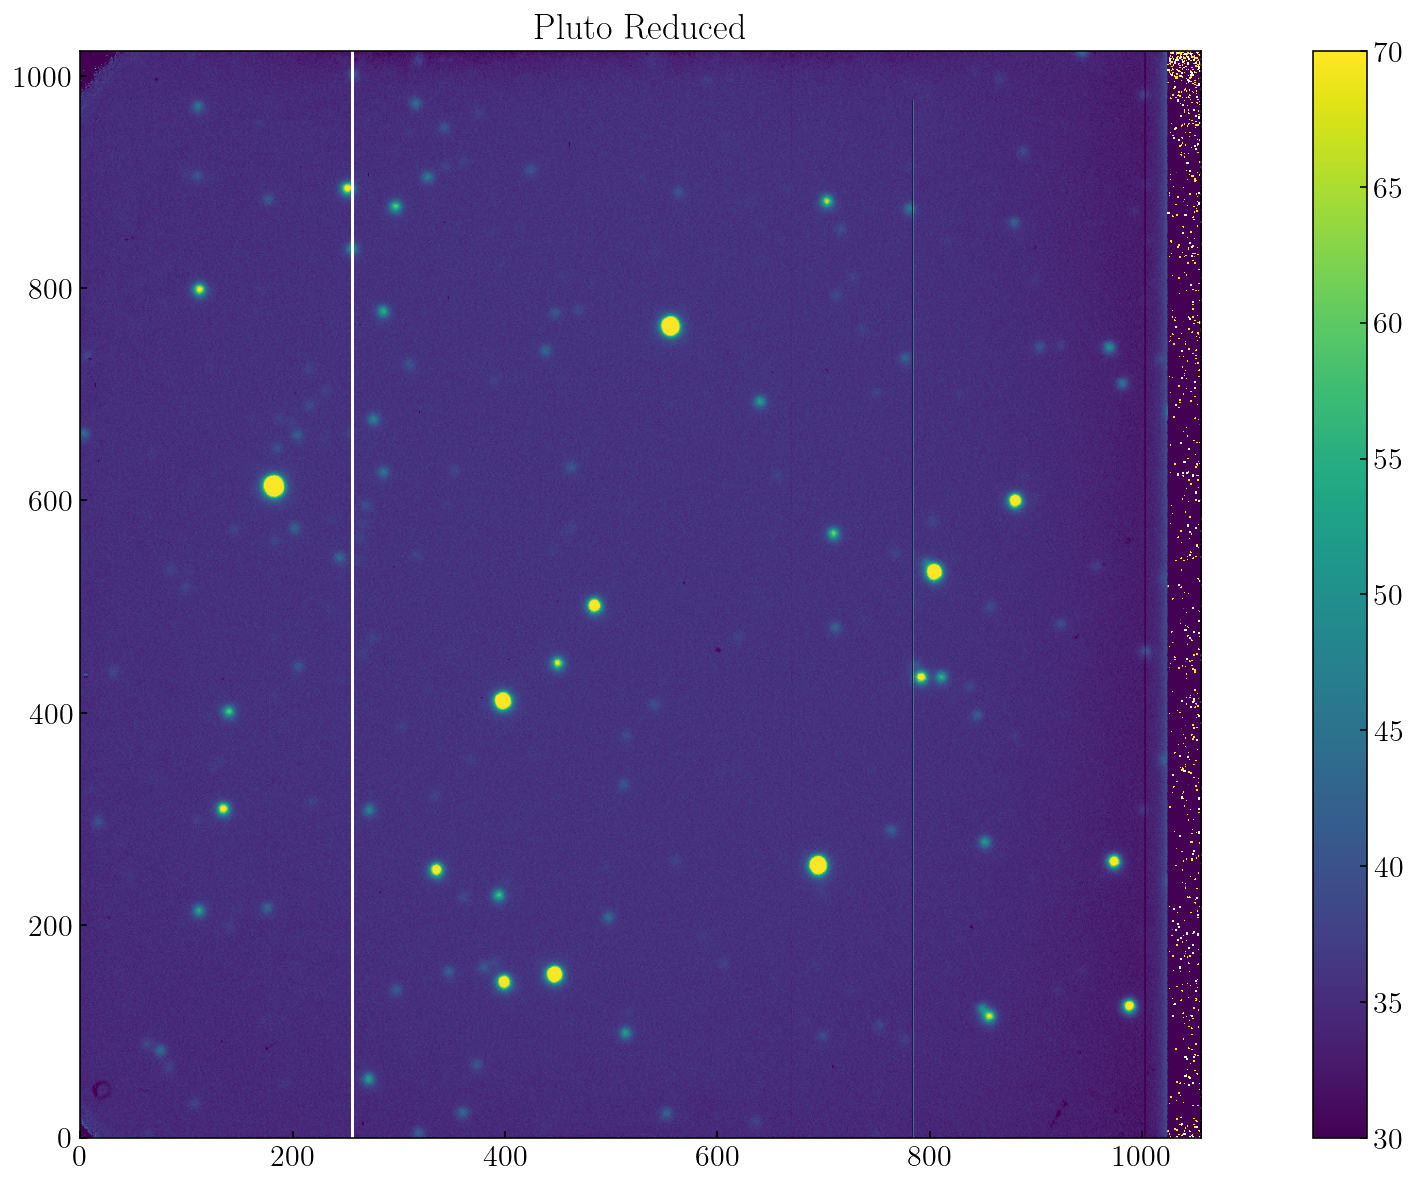

In [5]:
vrange=[30,70]

ObserveReducer(science,dark,flat,biases,vmin=vrange[0],vmax=vrange[1])